In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Data Preparation

In [2]:
df_train = pd.read_csv('train_data.csv') 
df_test = pd.read_csv('test_data.csv')

In [3]:

df_train = df_train.drop(columns=[
     'averageRating', 'originalTitle', 
])

df_test = df_test.drop(columns=[
     'averageRating', 'originalTitle', 
])

In [4]:
my_dict = {
    '(0, 1]': 0,
    '(1, 2]': 0,
    '(2, 3]': 0,
    '(3, 4]': 0,
    '(4, 5]': 1,
    '(5, 6]': 1,
    '(6, 7]': 2,
    '(7, 8]': 3,
    '(8, 9]': 4,
    '(9, 10]': 5,
}
df_train['rating'] = df_train['rating'].map(my_dict)
df_test['rating'] = df_test['rating'].map(my_dict)


In [5]:
X_train = df_train.drop(columns=["rating"])
y_train = df_train["rating"]
X_test = df_test.drop(columns=["rating"])
y_test = df_test["rating"]

In [6]:

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


# Normalization

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)    # Transform validation data
X_test  = scaler.transform(X_test)   # Transform test data

# Keras Deep Neural Networks

In [9]:
# !pip install scikeras

In [10]:
from scikeras.wrappers import KerasClassifier

In [11]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.optimizers import Adam

In [12]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # Layer 1 - 256 units
    act_1 = hp.Choice('activation_1', ['relu', 'tanh'])
    dropout_1 = hp.Float('dropout_1', 0.2, 0.4, step=0.1)
    model.add(Dense(128, activation=act_1,
                    input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_1))

    # Layer 2 - 128 units
    act_2 = hp.Choice('activation_2', ['relu', 'tanh'])
    dropout_2 = hp.Float('dropout_2', 0.2, 0.4, step=0.1)
    model.add(Dense(64, activation=act_2))
    model.add(Dropout(dropout_2))

    # Layer 3 - 64 units
    act_3 = hp.Choice('activation_3', ['relu', 'tanh'])
    dropout_3 = hp.Float('dropout_3', 0.2, 0.4, step=0.1)
    model.add(Dense(32, activation=act_3))
    model.add(Dropout(dropout_3))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Optimizer
    lr = hp.Choice('learning_rate', [0.001])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [13]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=150,
    executions_per_trial=1,
    directory='my_dir',
    project_name='3 layers_dropout hklllll',
    

)

c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
es = EarlyStopping(monitor='val_accuracy', patience=20, verbose=True)
mc = ModelCheckpoint('best_model_l2_tuning_3 layers_dropout_3.keras', monitor='val_accuracy', save_best_only=True)

In [16]:
tuner.search(X_train, y_train,
             epochs=500, 
             validation_data=(X_val, y_val),
             callbacks=[es, mc],)

Trial 150 Complete [00h 20m 08s]
val_accuracy: 0.43981480598449707

Best val_accuracy So Far: 0.44256365299224854
Total elapsed time: 22h 43m 10s


In [17]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
test_loss, test_accuracy


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(1.3046635389328003, 0.4363677203655243)

In [18]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,350 (52.15 KB)

 Trainable params: 13,350 (52.15 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

activation_1: relu
dropout_1: 0.2
activation_2: relu
dropout_2: 0.2
activation_3: relu
dropout_3: 0.30000000000000004
learning_rate: 0.001


<retrain best model on wrapper 

In [20]:
def build_model():
# 1. Build model using best hyperparameters
    model = Sequential([       
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])

# 2. Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
es = EarlyStopping(monitor='val_accuracy', patience=50, verbose=True)
mc = ModelCheckpoint('mdel_l2_3layers_best_123.keras', monitor='val_accuracy', save_best_only=True)


In [23]:
from scikeras.wrappers import KerasClassifier

In [24]:
clf = KerasClassifier(build_fn=build_model, callbacks=[es, mc])

In [25]:
clf.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2592/2592 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3709 - loss: 1.4890 - val_accuracy: 0.4076 - val_loss: 1.3851
Epoch 2/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4051 - loss: 1.4033 - val_accuracy: 0.4104 - val_loss: 1.3757
Epoch 3/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4118 - loss: 1.3876 - val_accuracy: 0.4147 - val_loss: 1.3624
Epoch 4/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4104 - loss: 1.3827 - val_accuracy: 0.4167 - val_loss: 1.3576
Epoch 5/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4158 - loss: 1.3740 - val_accuracy: 0.4185 - val_loss: 1.3526
Epoch 6/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4180 - loss: 1.3675 - val_accuracy: 0.4183 - val_loss: 1.3489
Epoch 7/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4175 - loss: 1.3647 - val_accuracy: 0.4213 - val_loss: 1.3407
Epoch 8/500
2592/2592 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.4198 - loss: 1.3604 - val

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x000002B0C5FDC310>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x000002B0C1A5FEE0>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002B0BC047AC0>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [26]:
y_pred = clf.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy 0.43717790030381454
F1-score [0.01150895 0.50064618 0.3291966  0.55086217 0.0939634  0.115797  ]
              precision    recall  f1-score   support

           0       0.53      0.01      0.01      1547
           1       0.51      0.49      0.50      9052
           2       0.39      0.28      0.33     11574
           3       0.43      0.78      0.55     14409
           4       0.46      0.05      0.09      6571
           5       0.69      0.06      0.12      1282

    accuracy                           0.44     44435
   macro avg       0.50      0.28      0.27     44435
weighted avg       0.45      0.44      0.38     44435



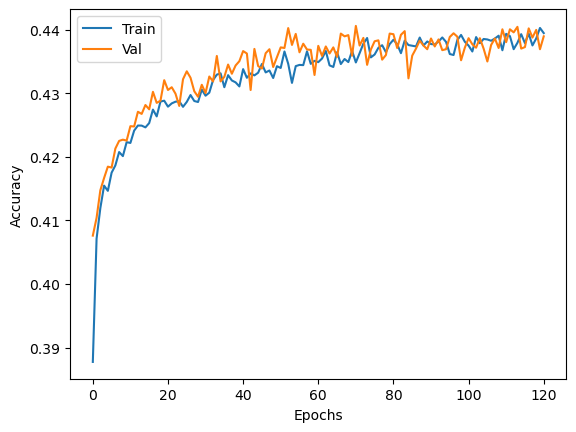

In [27]:
history = clf.history_
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

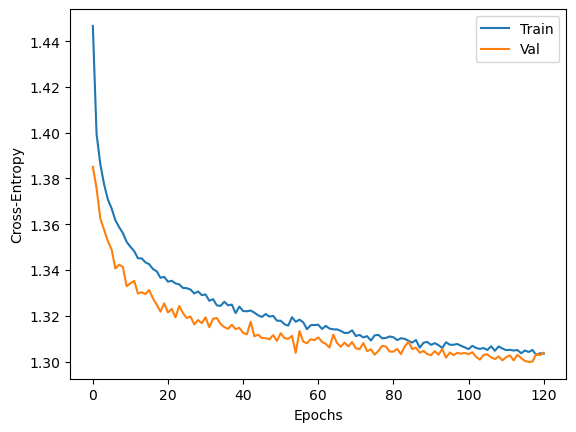

In [28]:
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

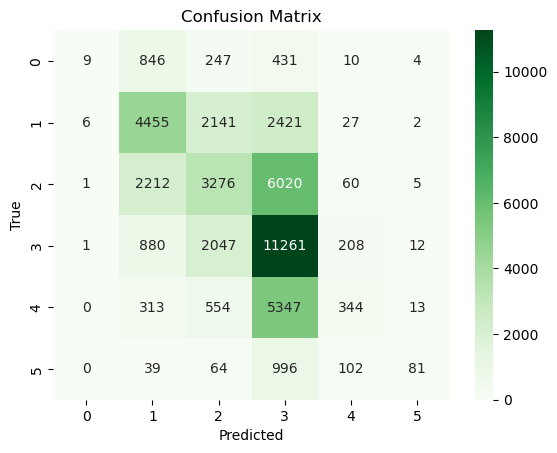

In [29]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')  # fmt='d' to show integer values
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [30]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


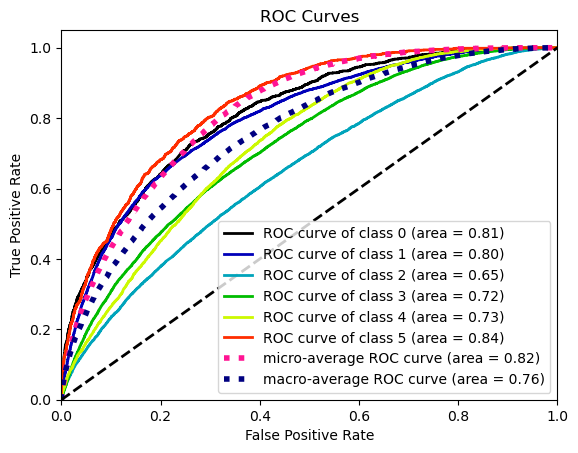

In [31]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


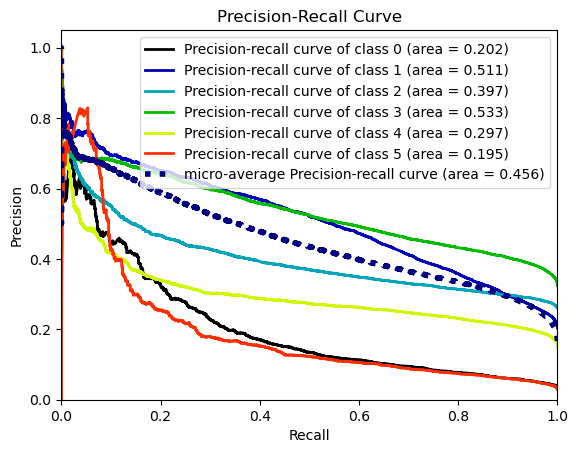

In [32]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.show()

In [33]:
import numpy as np
from sklearn.metrics import f1_score
import random

def predict_with_thresholds(probs, thresholds, default_class=None):
    preds = []
    for p in probs:
        passed = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if passed:
            selected = passed[np.argmax([p[i] for i in passed])]
        else:
            selected = default_class if default_class is not None else np.argmax(p)
        preds.append(selected)
    return np.array(preds)

def random_search_thresholds(probs, y_true, n_iter=1000):
    n_classes = probs.shape[1]
    best_f1 = 0
    best_thresh = [0.5] * n_classes
    random.seed(42)

    for _ in range(n_iter):
        thresholds = [round(random.uniform(0.1, 0.9), 2) for _ in range(n_classes)]
        y_pred = predict_with_thresholds(probs, thresholds)
        f1 = f1_score(y_true, y_pred, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresholds

    return best_thresh, best_f1


In [34]:
probs_test = clf.predict_proba(X_test)  # ✅
probs_test.shape  # → (n_samples, n_classes)

best_thresh, best_f1 = random_search_thresholds(probs_test, y_test, n_iter=1000)

print("Best thresholds:", best_thresh)
print("Best macro F1 on test set:", best_f1)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best thresholds: [0.11, 0.74, 0.82, 0.64, 0.23, 0.45]
Best macro F1 on test set: 0.32025223784544066


In [35]:
probs_test = clf.predict_proba(X_test)  # shape: (n_samples, 6)
y_pred = predict_with_thresholds(probs_test, best_thresh)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [36]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.40146281084730506
F1-score [0.21983471 0.47726334 0.32921314 0.46489593 0.3327098  0.0975965 ]
              precision    recall  f1-score   support

           0       0.30      0.17      0.22      1547
           1       0.51      0.45      0.48      9052
           2       0.39      0.28      0.33     11574
           3       0.42      0.53      0.46     14409
           4       0.29      0.39      0.33      6571
           5       0.74      0.05      0.10      1282

    accuracy                           0.40     44435
   macro avg       0.44      0.31      0.32     44435
weighted avg       0.42      0.40      0.39     44435



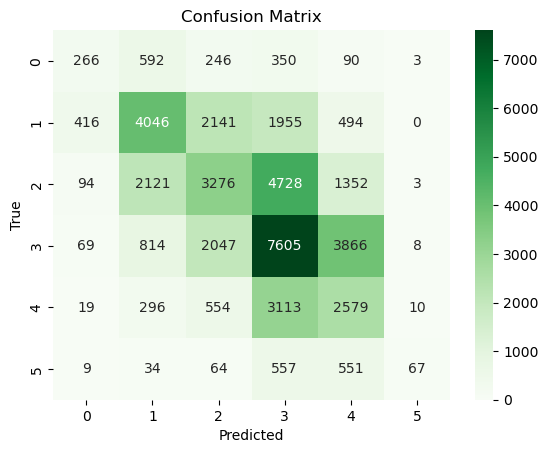

In [37]:
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True, cmap="Greens", fmt='d')  # fmt='d' to show integer values
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


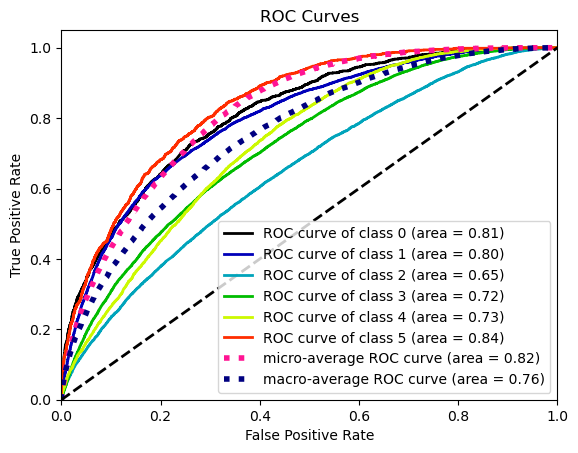

In [38]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score)
plt.show()